In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataframes of the different component
rooth_path = '../data/'
generator_train = pd.read_csv(rooth_path + 'generator_train.csv')
gen_bear_train = pd.read_csv(rooth_path + 'gen_bear_train.csv')
transformer_train = pd.read_csv(rooth_path + 'transformer_train.csv')
hydraulic_train = pd.read_csv(rooth_path + 'hydraulic_train.csv')
gearbox_train = pd.read_csv(rooth_path + 'gearbox_train.csv')
generator_test = pd.read_csv(rooth_path + 'generator_test.csv')
gen_bear_test = pd.read_csv(rooth_path + 'gen_bear_test.csv')
transformer_test = pd.read_csv(rooth_path + 'transformer_test.csv')
hydraulic_test = pd.read_csv(rooth_path + 'hydraulic_test.csv')
gearbox_test = pd.read_csv(rooth_path + 'gearbox_test.csv')
df_costs = pd.read_csv(rooth_path + 'training/HTW_Costs.csv')

### We are ready to build our base-model for each component. 

- We will need to scale the features, within each turbine
- Since we have a very unbalanced dataset we will use SMOTE for balancing the training data set
- Reach a base line model
- Try other algorithms and fine tune
- Probably we will need to change the threshold to reduce the FP
- Calculate the different costs of our best models

In [3]:
# Scale within each turbine
def scale (df_train, df_test, scaler='StandardScaler'):
    
    '''Scale within each given turbine
    
    Args:
            df_train      : Train datarame
            df_test       : Test dataframe
        
    Returns:
            array         : Scaled array of train and test'''
    
    
    # Scale for turbine T01 first
    X_train1 = df_train.loc[df_train['Turbine_ID']=='T01']
    X_test1 = df_test.loc[df_test['Turbine_ID']=='T01']

    X_train1 = X_train1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    X_test1 = X_test1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    
    if scaler == 'MinMaxScaler':
        sc = MinMaxScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    else:
        sc = StandardScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    
    # Scale on other turbines
    turbines = ['T06', 'T07', 'T09', 'T11']
    for turbine in turbines:
        X_train_ = df_train.loc[df_train['Turbine_ID']==turbine]
        X_test_ = df_test.loc[df_test['Turbine_ID']==turbine]

        X_train_ = X_train_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
        X_test_ = X_test_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])

        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        else:
            sc = StandardScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        
        # Concatenate
        X_train1 = np.concatenate((X_train1, X_train_))
        X_test1 = np.concatenate((X_test1, X_test_))
        
             
    return X_train1, X_test1

In [4]:
# Data augmentation using SMOTE
def data_aug(X_train, y_train):
    
    '''Function for data augmentation, using SMOTE
    
    
    '''
    all_classes = Counter(y_train)
    majority_class = all_classes.most_common(1)
    minority_class = all_classes.most_common()[1:]
    ratio = minority_class[0][1]/majority_class[0][1]
    
    # If ratio of training set < 10% 
    if ratio < 0.1:
        over = SMOTE(sampling_strategy=0.1, random_state=0) # 10% of positive examples
        X_train, y_train = over.fit_sample(X_train, y_train)    
    
    return X_train, y_train

In [5]:
# Function to predict
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
    
    #Grid Search
    grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    
    #Predictions
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [6]:
# Function for metrics
def metrics(estimator, X_test, y_test, y_pred):
    
    # Classification Report
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print(confusion_matrix(y_test, y_pred))
        
    #Roc Curve
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Precision Recall curve
    precision, recall, treshold = precision_recall_curve(y_test, y_pred)
    
    plt.figure(figsize=(15,5))
    
    # Plot Roc
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label= f'{estimator} AUC = %0.2f'% roc_auc)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
    
    # Plot Decision Recall
    plt.subplot(1,2,2)
    plt.plot(treshold, precision[:-1], c ='r', label ='Precision')
    plt.plot(treshold, recall[:-1], c ='b', label ='Recall')
    plt.xlabel("Treshold")
    plt.ylabel("%")
    plt.grid()
    plt.legend()
    
    plt.show()

In [7]:
# Logistic Regression
def logreg(X_train, X_test, y_train, y_test):
    model = 'Logistic Regression'
    clf_logreg = LogisticRegression(random_state=42, max_iter=3000, n_jobs=-1)
    gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
    gs_score = 'roc_auc'

    clf_logreg, pred_logreg = bin_classify(model, clf_logreg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_logreg)
    
    metrics(clf_logreg, X_test, y_test, pred_logreg['y_pred'])
    
    return clf_logreg, pred_logreg

In [8]:
# Random Forest Classifier
def rfc(X_train, X_test, y_train, y_test):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'max_depth': [4, 5, 6, 7, 8, 10, 15, 20], 'criterion': ['gini', 'entropy']}
    gs_score = 'roc_auc'

    clf_rfc, pred_rfc = bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)
    
    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'])
    
    return clf_rfc, pred_rfc

In [9]:
# Gradient Boosting Classifier
def gbc(X_train, X_test, y_train, y_test):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.5, 0.6, 0.8, 1]}
    gs_score = 'roc_auc'

    clf_gbc, pred_gbc= bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'])
    
    return clf_gbc, pred_gbc

In [10]:
# K-Neighbors
def knn(X_train, X_test, y_train, y_test):
    model = 'KNN'
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    gs_params = {'n_neighbors': [5, 7, 10, 15]}
    gs_score = 'roc_auc'

    clf_knn, pred_knn= bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'])
    
    return clf_knn, pred_knn

In [11]:
# Ada Boost Classifier
def abc(X_train, X_test, y_train, y_test):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]}
    gs_score = 'roc_auc'

    clf_abc, pred_abc= bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'])
    
    return clf_abc, pred_abc

In [12]:
# SVC
def svc(X_train, X_test, y_train, y_test):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'gamma': ['auto', 'scale']}
    gs_score = 'roc_auc'

    clf_svc, pred_svc= bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'])
    
    return clf_svc, pred_svc

In [13]:
# Naive Bayes
def gnb(X_train, X_test, y_train, y_test):
    model = 'Gaussian NB'
    clf_gnb = GaussianNB()
    gs_params = {}
    gs_score = 'roc_auc'

    clf_gnb, pred_gnb= bin_classify(model, clf_gnb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gnb)

    metrics(clf_gnb, X_test, y_test, pred_gnb['y_pred'])
    
    return clf_gnb, pred_gnb

# 1st Analysis - Base Models

## GENERATOR

In [14]:
# By exploration, drop columns:
gen_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 
                'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd', 
                'Gen_Phase2_Temp_Avg', 'Gen_Phase2_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_sd', 
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_InverterPhase1_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg_av', 'Grd_InverterPhase1_Temp_Avg_sd']

In [15]:
# Drop columns
generator_train_ = generator_train.drop(columns = gen_col_drop)
generator_test_ = generator_test.drop(columns = gen_col_drop)

In [16]:
# Scale
X_train_gen, X_test_gen = scale(generator_train_, generator_test_)

In [17]:
# Define target and Data Augmentation on training data
y_train_gen = generator_train['Failure']
y_test_gen = generator_test['Failure']
X_train_gen, y_train_gen = data_aug(X_train_gen, y_train_gen)


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.78      1220
   macro avg       0.47      0.41      0.44      1220
weighted avg       0.90      0.78      0.83      1220

[[947 214]
 [ 59   0]]


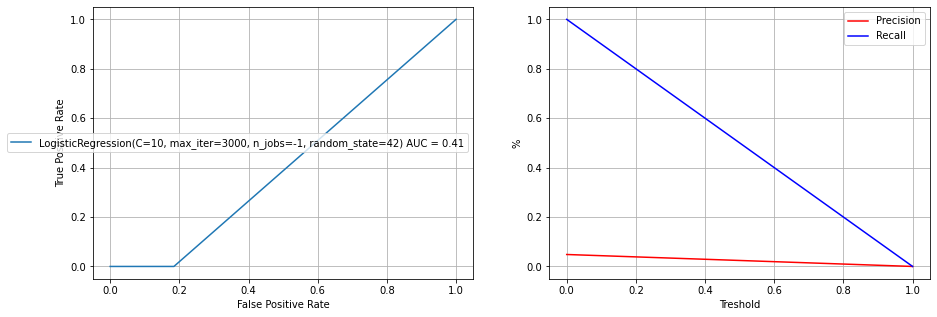


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


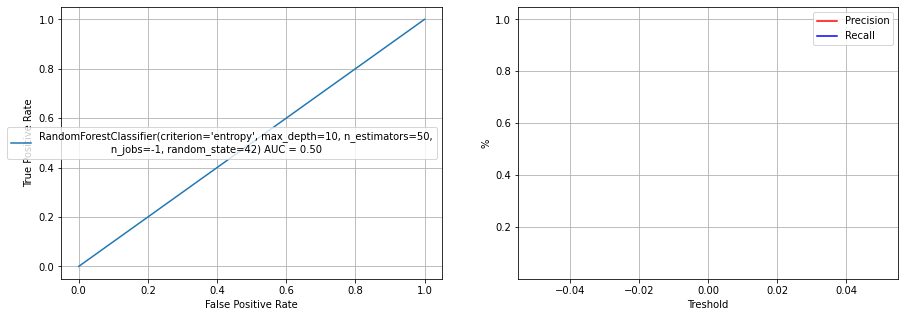

KeyboardInterrupt: 

In [18]:
clf_logreg_gen, pred_logreg_gen = logreg(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_rfc_gen, pred_rfc_gen = rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gbc_gen, pred_gbc_gen = gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_knn_gen, pred_knn_gen = knn(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_abc_gen, pred_abc_gen = abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_svc_gen, pred_svc_gen = svc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gnb_gen, pred_gnb_gen = gnb(X_train_gen, X_test_gen, y_train_gen, y_test_gen)

## GENERATOR BEARING

In [ ]:
# By exploration, drop columns:
bear_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 
                'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd', 
                'Gen_Phase2_Temp_Avg', 'Gen_Phase2_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_sd', 
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                 'Grd_InverterPhase1_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg_av', 'Grd_InverterPhase1_Temp_Avg_sd']

In [ ]:
# Drop columns
gen_bear_train_ = gen_bear_train.drop(columns = bear_col_drop)
gen_bear_test_ = gen_bear_test.drop(columns = bear_col_drop)

In [ ]:
# Scale
X_train_bear, X_test_bear = scale(gen_bear_train_, gen_bear_test_)

In [ ]:
# Define target and Data Augmentation on training data
y_train_bear = gen_bear_train['Failure']
y_test_bear = gen_bear_test['Failure']
X_train_bear, y_train_bear = data_aug(X_train_bear, y_train_bear)

In [ ]:
clf_logreg_bear, pred_logreg_bear = logreg(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_rfc_bear, pred_rfc_bear = rfc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gbc_bear, pred_gbc_bear = gbc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_knn_bear, pred_knn_bear = knn(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_abc_bear, pred_abc_bear = abc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_svc_bear, pred_svc_bear = svc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gnb_bear, pred_gnb_bear = gnb(X_train_bear, X_test_bear, y_train_bear, y_test_bear)

## TRANSFORMER

In [ ]:
# By exploration, drop columns:
transf_col_drop = ['HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase2_Temp_Avg_sd', 
                   'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                   'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                   'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                   'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                   'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd', 
                   'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                   'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                   'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [ ]:
# Drop columns
transformer_train_ = transformer_train.drop(columns = transf_col_drop)
transformer_test_ = transformer_test.drop(columns = transf_col_drop)

In [ ]:
# Scale
X_train_transf, X_test_transf = scale(transformer_train_, transformer_test_)

In [ ]:
# Define target and Data Augmentation on training data
y_train_transf = transformer_train['Failure']
y_test_transf = transformer_test['Failure']
X_train_transf, y_train_transf = data_aug(X_train_transf, y_train_transf)

In [ ]:
clf_logreg_transf, pred_logreg_transf = logreg(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_rfc_transf, pred_rfc_transf = rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gbc_transf, pred_gbc_transf = gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_knn_transf, pred_knn_transf = knn(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_abc_transf, pred_abc_transf = abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_svc_transf, pred_svc_transf = svc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gnb_transf, pred_gnb_transf = gnb(X_train_transf, X_test_transf, y_train_transf, y_test_transf)

## HYDRAULIC

In [ ]:
# By exploration, drop columns:
hyd_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd', 
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [ ]:
# Drop columns
hydraulic_train_ = hydraulic_train.drop(columns = hyd_col_drop)
hydraulic_test_ = hydraulic_test.drop(columns = hyd_col_drop)

In [ ]:
# Scale
X_train_hyd, X_test_hyd = scale(hydraulic_train_, hydraulic_test_)

In [ ]:
# Define target and Data Augmentation on training data
y_train_hyd = hydraulic_train['Failure']
y_test_hyd = hydraulic_test['Failure']
X_train_hyd, y_train_hyd = data_aug(X_train_hyd, y_train_hyd)

In [ ]:
clf_logreg_hyd, pred_logreg_hyd = logreg(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_rfc_hyd, pred_rfc_hyd = rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gbc_hyd, pred_gbc_hyd = gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_knn_hyd, pred_knn_hyd = knn(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_abc_hyd, pred_abc_hyd = abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_svc_hyd, pred_svc_hyd = svc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gnb_hyd, pred_gnb_hyd = gnb(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)

## GEARBOX

In [ ]:
# By exploration, drop columns:
gear_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd', 
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd', 
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd', 
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd', 
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd', 
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [ ]:
# Drop columns
gearbox_train_ = gearbox_train.drop(columns = gear_col_drop)
gearbox_test_ = gearbox_test.drop(columns = gear_col_drop)

In [ ]:
# Scale
X_train_gear, X_test_gear = scale(gearbox_train_, gearbox_test_)

In [ ]:
# Define target and Data Augmentation on training data
y_train_gear = gearbox_train['Failure']
y_test_gear = gearbox_test['Failure']
X_train_gear, y_train_gear = data_aug(X_train_gear, y_train_gear)

In [ ]:
clf_logreg_gear, pred_logreg_gear = logreg(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_rfc_gear, pred_rfc_gear = rfc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gbc_gear, pred_gbc_gear = gbc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_knn_gear, pred_knn_gear = knn(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_abc_gear, pred_abc_gear = abc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_svc_gear, pred_svc_gear = svc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gnb_gear, pred_gnb_gear = gnb(X_train_gear, X_test_gear, y_train_gear, y_test_gear)

### Our models are not good

# 2nd Analysis - Try improvements

##### Let's see if we can improve our models just by choosing ONLY the input features for each component

## GENERATOR

In [ ]:
generator_train_2 = generator_train[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                    'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                    'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                    'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                    'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd',
                                    'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                    'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]
generator_test_2 = generator_test[['Turbine_ID', 'Date','TTF', 'Failure','Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
                                    'Gen_RPM_Std', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                                    'Gen_SlipRing_Temp_Avg', 'Gen_RPM_Max_av', 'Gen_RPM_Min_av', 'Gen_RPM_Avg_av', 
                                    'Gen_RPM_Std_av', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av', 
                                    'Gen_Phase3_Temp_Avg_av', 'Gen_SlipRing_Temp_Avg_av', 'Gen_RPM_Max_sd', 'Gen_RPM_Min_sd',
                                    'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd', 'Gen_Phase1_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                                    'Gen_Phase3_Temp_Avg_sd', 'Gen_SlipRing_Temp_Avg_sd']]

In [ ]:
# Scale
X_train_gen_2, X_test_gen_2 = scale(generator_train_2, generator_test_2)

In [ ]:
# Define target and Data Augmentation on training data
y_train_gen_2 = generator_train['Failure']
y_test_gen_2 = generator_test['Failure']
X_train_gen_2, y_train_gen_2 = data_aug(X_train_gen_2, y_train_gen_2)

In [ ]:
clf_logreg_gen_2, pred_logreg_gen_2 = logreg(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_rfc_gen_2, pred_rfc_gen_2 = rfc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gbc_gen_2, pred_gbc_gen_2 = gbc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_knn_gen_2, pred_knn_gen_2 = knn(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_abc_gen_2, pred_abc_gen_2 = abc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_svc_gen_2, pred_svc_gen_2 = svc(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)
clf_gnb_gen_2, pred_gnb_gen_2 = gnb(X_train_gen_2, X_test_gen_2, y_train_gen_2, y_test_gen_2)

## GENERATOR BEARING

In [ ]:
gen_bear_train_2 = gen_bear_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd',
                                  'Gen_Bear2_Temp_Avg_sd']]
gen_bear_test_2 = gen_bear_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gen_Bear_Temp_Avg', 'Gen_Bear2_Temp_Avg',
                                 'Gen_Bear_Temp_Avg_av', 'Gen_Bear2_Temp_Avg_av', 'Gen_Bear_Temp_Avg_sd',
                                  'Gen_Bear2_Temp_Avg_sd']]

In [ ]:
# Scale
X_train_bear_2, X_test_bear_2 = scale(gen_bear_train_2, gen_bear_test_2)
# X_train_bear_2 = gen_bear_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_bear_2 = gen_bear_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [ ]:
# Define target and Data Augmentation on training data
y_train_bear_2 = gen_bear_train['Failure']
y_test_bear_2 = gen_bear_test['Failure']
X_train_bear_2, y_train_bear_2 = data_aug(X_train_bear_2, y_train_bear_2)

In [ ]:
clf_logreg_bear_2, pred_logreg_bear_2 = logreg(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_rfc_bear_2, pred_rfc_bear_2 = rfc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gbc_bear_2, pred_gbc_bear_2 = gbc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_knn_bear_2, pred_knn_bear_2 = knn(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_abc_bear_2, pred_abc_bear_2 = abc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_svc_bear_2, pred_svc_bear_2 = svc(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)
clf_gnb_bear_2, pred_gnb_bear_2 = gnb(X_train_bear_2, X_test_bear_2, y_train_bear_2, y_test_bear_2)

## TRANSFORMER

In [ ]:
transformer_train_2 = transformer_train[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 
                                        'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av',
                                        'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                                        'HVTrafo_Phase2_Temp_Avg_sd', 'HVTrafo_Phase3_Temp_Avg_sd']]
transformer_test_2 = transformer_test[['Turbine_ID', 'Date','TTF', 'Failure', 'HVTrafo_Phase1_Temp_Avg', 
                                        'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av',
                                        'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase3_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd', 
                                        'HVTrafo_Phase2_Temp_Avg_sd', 'HVTrafo_Phase3_Temp_Avg_sd']]

In [ ]:
# Scale
#X_train_transf_2, X_test_transf_2 = scale(transformer_train_2, transformer_test_2)
X_train_transf_2 = transformer_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
X_test_transf_2 = transformer_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [ ]:
# Define target and Data Augmentation on training data
y_train_transf_2 = transformer_train['Failure']
y_test_transf_2 = transformer_test['Failure']
X_train_transf_2, y_train_transf_2 = data_aug(X_train_transf_2, y_train_transf_2)

In [ ]:
clf_logreg_transf_2, pred_logreg_transf_2 = logreg(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_rfc_transf_2, pred_rfc_transf_2 = rfc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gbc_transf_2, pred_gbc_transf_2 = gbc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_knn_transf_2, pred_knn_transf_2 = knn(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_abc_transf_2, pred_abc_transf_2 = abc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_svc_transf_2, pred_svc_transf_2 = svc(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)
clf_gnb_transf_2, pred_gnb_transf_2 = gnb(X_train_transf_2, X_test_transf_2, y_train_transf_2, y_test_transf_2)

## HYDRAULIC

In [ ]:
hydraulic_train_2 = hydraulic_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                     'Hyd_Oil_Temp_Avg_sd']]
hydraulic_test_2 = hydraulic_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Hyd_Oil_Temp_Avg', 'Hyd_Oil_Temp_Avg_av',
                                   'Hyd_Oil_Temp_Avg_sd']]

In [ ]:
# Scale
X_train_hyd_2, X_test_hyd_2 = scale(hydraulic_train_2, hydraulic_test_2)
# X_train_hyd_2 = hydraulic_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_hyd_2 = hydraulic_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [ ]:
# Define target and Data Augmentation on training data
y_train_hyd_2 = hydraulic_train['Failure']
y_test_hyd_2 = hydraulic_test['Failure']
X_train_hyd_2, y_train_hyd_2 = data_aug(X_train_hyd_2, y_train_hyd_2)

In [ ]:
clf_logreg_hyd_2, pred_logreg_hyd_2 = logreg(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_rfc_hyd_2, pred_rfc_hyd_2 = rfc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gbc_hyd_2, pred_gbc_hyd_2 = gbc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_knn_hyd_2, pred_knn_hyd_2 = knn(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_abc_hyd_2, pred_abc_hyd_2 = abc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_svc_hyd_2, pred_svc_hyd_2 = svc(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)
clf_gnb_hyd_2, pred_gnb_hyd_2 = gnb(X_train_hyd_2, X_test_hyd_2, y_train_hyd_2, y_test_hyd_2)

## GEARBOX

In [ ]:
gearbox_train_2 = gearbox_train[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]
gearbox_test_2 = gearbox_test[['Turbine_ID', 'Date','TTF', 'Failure', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg',
                                'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd']]

In [ ]:
# Scale
X_train_gear_2, X_test_gear_2 = scale(gearbox_train_2, gearbox_test_2)
# X_train_gear_2 = gearbox_train_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour
# X_test_gear_2 = gearbox_test_2.drop(columns=['Turbine_ID', 'Date','TTF', 'Failure']) #Not scale - maybe it finds abnormal behaviour

In [ ]:
# Define target and Data Augmentation on training data
y_train_gear_2 = gearbox_train['Failure']
y_test_gear_2 = gearbox_test['Failure']
X_train_gear_2, y_train_gear_2 = data_aug(X_train_gear_2, y_train_gear_2)

In [ ]:
clf_logreg_gear_2, pred_logreg_gear_2 = logreg(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_rfc_gear_2, pred_rfc_gear_2 = rfc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gbc_gear_2, pred_gbc_gear_2 = gbc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_knn_gear_2, pred_knn_gear_2 = knn(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_abc_gear_2, pred_abc_gear_2 = abc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_svc_gear_2, pred_svc_gear_2 = svc(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)
clf_gnb_gear_2, pred_gnb_gear_2 = gnb(X_train_gear_2, X_test_gear_2, y_train_gear_2, y_test_gear_2)

## NOTE:

- From now on we will choose the final models. We could fine tune the models in very different ways like different period for rolling aggreggates, more feature engineering (peaks, min, max, median, nº of outliers, etc), different model parameters, new models, different features, retrieve more data, etc. We could also test regression models (ttf)
- Since this is a first project and we want to proceed to different stages, just for the purpose of learning, We will just define a threshold to decrease the number of the FP and calculate our costs savings
- We do not have a validation set to validate if the models generalize well
- Deploy into production

In [ ]:
df_costs

#### Thresholds
- We will change the default threshold (0.5), according to the business perspective

In [ ]:
# Generator
plt.figure(figsize=(15,5)) 
plt.subplot(1, 3, 1)
sns.boxplot(x=y_test_gen, y=pred_gbc_gen['y_score'])
plt.title('pred_gbc_gen')
plt.subplot(1, 3, 2)
sns.boxplot(x=y_test_gen_2, y=pred_rfc_gen_2['y_score'])
plt.title('pred_rfc_gen_2')
plt.subplot(1, 3, 3)
sns.boxplot(x=y_test_gen_2, y=pred_gbc_gen_2['y_score'])
plt.title('pred_gbc_gen_2')


In [ ]:
# Generator Bearing
plt.figure(figsize=(7,5)) 
sns.boxplot(x=y_test_bear, y=pred_abc_bear['y_score'])
plt.title('pred_abc_bear')

In [ ]:
# Transformer
plt.figure(figsize=(15,10)) 
plt.subplot(2, 2, 1)
sns.boxplot(x=y_test_transf, y=pred_gnb_transf['y_score'])
plt.title('pred_gnb_transf')
plt.subplot(2, 2, 2)
sns.boxplot(x=y_test_transf_2, y=pred_gbc_transf_2['y_score'])
plt.title('pred_gbc_transf_2')
plt.subplot(2, 2, 3)
sns.boxplot(x=y_test_transf_2, y=pred_knn_transf_2['y_score'])
plt.title('pred_knn_transf_2')
plt.subplot(2, 2, 4)
sns.boxplot(x=y_test_transf_2, y=pred_abc_transf_2['y_score'])
plt.title('pred_abc_transf_2')

In [ ]:
# Hydraulic
plt.figure(figsize=(15,5)) 
plt.subplot(1, 2, 1)
sns.boxplot(x=y_test_hyd, y=pred_logreg_hyd['y_score'])
plt.title('pred_logreg_hyd')
plt.subplot(1, 2, 2)
sns.boxplot(x=y_test_hyd, y=pred_gbc_hyd['y_score'])
plt.title('pred_gbc_hyd')

In [ ]:
# Gearbox
plt.figure(figsize=(15,5)) 
plt.subplot(1, 3, 1)
sns.boxplot(x=y_test_gear_2, y=pred_abc_gear_2['y_score'])
plt.title('pred_abc_gear_2')
plt.subplot(1, 3, 2)
sns.boxplot(x=y_test_gear_2, y=pred_knn_gear_2['y_score'])
plt.title('pred_knn_gear_2')
plt.subplot(1, 3, 3)
sns.boxplot(x=y_test_gear_2, y=pred_gnb_gear_2['y_score'])
plt.title('pred_gnb_gear_2')

#### From a business prespective, we will assume that we send a technical repair employee only with 20 days interval. So, if our model predicts a failure in day 1 and day 15, the employee will only go 1 time to run diagnosis/repair on the turbine